# Next Character Prediction with RNN's

We will not only predict the next characters, but we will also try to predict every next character

In [104]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import *
from cs231n.classifiers.rnn import *
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from metu.data_utils import load_nextchar_dataset, plain_text_file_to_dataset

In [60]:
# Load the TEXT data
# If your memory turns out to be sufficient, try the following:
#def get_nextchar_data(training_ratio=0.6, val_ratio=0.1):
def get_nextchar_data(training_ratio=0.1, test_ratio=0.06, val_ratio=0.01):
  # Load the nextchar training data 
  X, y = load_nextchar_dataset(nextchar_datafile)
  # Subsample the data
  length=len(y)
  num_training=int(length*training_ratio)
  num_val = int(length*val_ratio)
  num_test = min((length-num_training-num_val), int(length*test_ratio))
  mask = range(num_training-1)
  X_train = X[mask]
  y_train = y[mask]
  mask = range(num_training, num_training+num_test)
  X_test = X[mask]
  y_test = y[mask]
  mask = range(num_training+num_test, num_training+num_test+num_val)
  X_val = X[mask]
  y_val = y[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

nextchar_datafile = 'metu/dataset/nextchar_data.pkl'
input_size = 5 # Size of the input of the network
#plain_text_file_to_dataset("metu/dataset/ince_memed_1.txt", nextchar_datafile, input_size)
plain_text_file_to_dataset("metu/dataset/shakespeare.txt", nextchar_datafile, input_size)
X_train, y_train, X_val, y_val, X_test, y_test = get_nextchar_data()

NX_train = np.zeros((X_train.shape[0], input_size+1, 1))
for i in xrange(X_train.shape[0]):
    for j in xrange(input_size):
        NX_train[i,j,0] = X_train[i,j]
    NX_train[i,input_size,0] = y_train[i]

NX_test = np.zeros((X_test.shape[0], input_size+1, 1))
for i in xrange(X_test.shape[0]):
    for j in xrange(input_size):
        NX_test[i,j,0] = X_test[i,j]
    NX_test[i,input_size,0] = y_test[i]
        
NX_val = np.zeros((X_val.shape[0], input_size+1, 1))
for i in xrange(X_val.shape[0]):
    for j in xrange(input_size):
        NX_val[i,j,0] = X_val[i,j]
    NX_val[i,input_size,0] = y_val[i]

X_train, X_val, X_test = NX_train, NX_val, NX_test
print "Number of instances in the training set: ", len(X_train)
print "Number of instances in the validation set: ", len(X_val)
print "Number of instances in the testing set: ", len(X_test)

Converting plain text file to trainable dataset (as pickle file)
Processing file metu/dataset/shakespeare.txt as input
input_size parameter (i.e. num of neurons) will be 5
Writing data and labels to file metu/dataset/nextchar_data.pkl
Loading X and Y from pickle file metu/dataset/nextchar_data.pkl
Number of instances in the training set:  37647
Number of instances in the validation set:  3764
Number of instances in the testing set:  22589


In the above code, we reformatedd X_train, X_val and X_test to timed parts so that they are suitable for use in RNN's now.

In [125]:
# We have loaded the dataset. That wasn't difficult, was it? :)
# Let's look at a few samples
#
from metu.data_utils import int_list_to_string, int_to_charstr

print "Input - Next char to be predicted"
for i in range(1,10):
    print int_list_to_string(X_train[i]) + " - " + int_list_to_string(y_train[i])

Input - Next char to be predicted
HE SON - N
E SONN - N
 SONNE - E
SONNET - T
ONNETS - S
by Wil - l
y Will - l
 Willi - i
Willia - a


I simply modified the code for CapitoningRNN to get rid of initial hidden state that has been feed from CNN, instead I give all zeros, and also get rid of word embedding layer since we are going to use characters we could use just their ascii representative.

Also in the loss and sample function there are a few modifications to reflect those changes.

(Iteration 1 / 18800) loss: 34.658135
(Iteration 101 / 18800) loss: 12.512869
(Iteration 201 / 18800) loss: 10.823078
(Iteration 301 / 18800) loss: 9.693160
(Iteration 401 / 18800) loss: 10.800507
(Iteration 501 / 18800) loss: 9.001371
(Iteration 601 / 18800) loss: 8.611452
(Iteration 701 / 18800) loss: 7.388417
(Iteration 801 / 18800) loss: 8.138009
(Iteration 901 / 18800) loss: 10.116934
(Iteration 1001 / 18800) loss: 6.771510
(Iteration 1101 / 18800) loss: 7.558995
(Iteration 1201 / 18800) loss: 7.157235
(Iteration 1301 / 18800) loss: 6.536156
(Iteration 1401 / 18800) loss: 7.373561
(Iteration 1501 / 18800) loss: 7.531563
(Iteration 1601 / 18800) loss: 6.056296
(Iteration 1701 / 18800) loss: 7.522122
(Iteration 1801 / 18800) loss: 6.186926
(Iteration 1901 / 18800) loss: 8.257967
(Iteration 2001 / 18800) loss: 5.662087
(Iteration 2101 / 18800) loss: 6.062511
(Iteration 2201 / 18800) loss: 5.716082
(Iteration 2301 / 18800) loss: 5.441693
(Iteration 2401 / 18800) loss: 6.314132
(Iterat

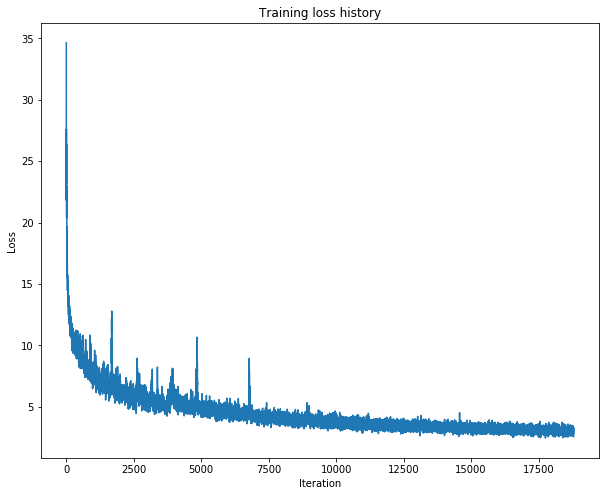

In [124]:
small_rnn_model = NextCharRNN(
          cell_type='rnn',
          input_dim=input_size,
          hidden_dim=512,
          charvec_dim=1,
        )

small_rnn_solver = NextCharSolver(small_rnn_model, X_train,
           update_rule='adam',
           num_epochs=50,
           batch_size=100,
           optim_config={
             'learning_rate': 1e-2,
           },
           lr_decay=0.95,
           verbose=True, print_every=100,
         )
small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [126]:
mbs=10
idx = np.random.choice(len(X_train), mbs)
minibatch = X_train[idx]
next_chars = small_rnn_model.sample(minibatch, 6)
print 'Training Data:'
for i in xrange(mbs):
    print 'Predicted string:', int_list_to_string(next_chars[i,:])
    print 'Real string:', int_list_to_string(minibatch[i,:])
    print

idx = np.random.choice(len(X_val), mbs)
minibatch = X_val[idx]
next_chars = small_rnn_model.sample(minibatch, 6)
print 'Validation Data:'
for i in xrange(mbs):
    print 'Predicted string:', int_list_to_string(next_chars[i,:])
    print 'Real string:', int_list_to_string(minibatch[i,:])
    print


Training Data:
Predicted string:  my fa
Real string:  my fa

Predicted string:  know 
Real string:  know,

Predicted string: herina
Real string: herina

Predicted string: aour  
Real string: bour, 

Predicted string: hr? ho
Real string: ir? ho

Predicted string: Iucrec
Real string: Lucrec

Predicted string:  to al
Real string:  to al

Predicted string: eive m
Real string: give m

Predicted string: s Iath
Real string: r Kath

Predicted string:  oath 
Real string:  oath,

Validation Data:
Predicted string: hll wi
Real string: ill wi

Predicted string:  such 
Real string:  such 

Predicted string:  loue 
Real string:  love 

Predicted string: I may 
Real string: I may 

Predicted string: oe in 
Real string: ne in 

Predicted string: Art to
Real string: Art to

Predicted string:       
Real string:       

Predicted string: aooare
Real string: appare

Predicted string:  lusty
Real string:  lusty

Predicted string: oe unw
Real string: ne unw



We can see that compared to our 2 Layer FCN approach in HW1 RNN's perform quite better. Even with a Softmax Loss of 3, which can be improved as can be seen from loss history graph.